Pretraining Autoencoder for Downstream Task
=====

## Overview 

In this notebook, we use the pretrained encoder of a mini VGG-based autoencoder as a feature extractor for a neural network.

## Setup 

We setup our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__author__ = 'Abien Fred Agarap'
__version__ = '1.0.0'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tf.vgg_ae import CAE

Set the memory growth of GPU.

In [2]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0],
    True
)

Set the random number generator seed value.

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

We set the batch size and epochs.

In [4]:
batch_size = 512
epochs = 100

## Dataset

We load the MNIST classification dataset.

In [5]:
(train_features, train_labels), (test_features, test_labels) = mnist.load_data()

We further split the test dataset into validation and test.

In [6]:
validation_features = test_features[:5000]
validation_labels = test_labels[:5000]

test_features = test_features[5000:]
test_labels = test_labels[5000:]

We preprocess the MNIST dataset.

In [7]:
train_features = train_features.reshape(-1, 28, 28, 1)
train_features = train_features.astype('float32')
train_features = train_features / 255.

validation_features = validation_features.reshape(-1, 28, 28, 1)
validation_features = validation_features.astype('float32')
validation_features = validation_features / 255.

test_features = test_features.reshape(-1, 28, 28, 1)
test_features = test_features.astype('float32')
test_features = test_features / 255.

train_labels = tf.one_hot(train_labels, len(np.unique(train_labels)))
validation_labels = tf.one_hot(validation_labels, len(np.unique(validation_labels)))
test_labels = tf.one_hot(test_labels, len(np.unique(test_labels)))

Create the `tf.data.Dataset` object for training and evaluation.

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(batch_size * 4)
train_dataset = train_dataset.shuffle(train_features.shape[0])

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(batch_size * 4)
validation_dataset = validation_dataset.shuffle(validation_features.shape[0])

test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = train_dataset.batch(batch_size)
test_dataset = train_dataset.prefetch(batch_size * 4)
test_dataset = train_dataset.shuffle(test_features.shape[0])

Instantiate the mini VGG-based autoencoder model.

In [9]:
model = CAE(input_shape=(28, 28, 1))

Compile the model.

In [10]:
model.compile(
    loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(learning_rate=1e-3)
)

Load the trained autoencoder model.

In [11]:
model.load_weights('../assets/export/mnist/mini_vgg_ae_mnist')

Visualize the test data and the model reconstructions.

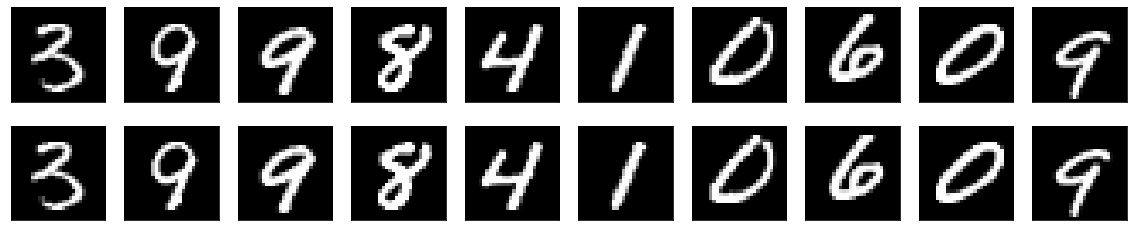

In [12]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(test_features[index].reshape(-1, 28, 28, 1)).numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Let's check the number of parameters.

In [13]:
model.summary()

Model: "cae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  64992     
_________________________________________________________________
decoder (Decoder)            multiple                  92609     
Total params: 157,601
Trainable params: 157,601
Non-trainable params: 0
_________________________________________________________________


View the encoder layers to be used as feature extractors.

In [14]:
model.encoder.layers

Un-freeze the encoder layer.

In [15]:
model.encoder.trainable = True

Build a neural network with `model.encoder` as feature extractor.

In [16]:
class NN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NN, self).__init__()
        self.encoder = model.encoder
        self.flatten = tf.keras.layers.Flatten()
        self.dense_layer = tf.keras.layers.Dense(units=512, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
        
    def call(self, features):
        code = self.encoder(features)
        code = self.flatten(code)
        activation = self.dense_layer(code)
        outputs = self.output_layer(activation)
        return outputs

Instantiate the neural network.

In [17]:
clf = NN()

Let's set an early stopping.

In [18]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=1e-4,
    patience=10
)

Compile the neural network for training and inference.

In [19]:
clf.compile(loss=tf.losses.categorical_crossentropy,
            optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            metrics=['accuracy'])

Train the model.

In [20]:
history = clf.fit(train_dataset,
                  epochs=epochs,
                  validation_data=validation_dataset,
                  callbacks=[early_stop_callback],
                  verbose=2)

Epoch 1/100
118/118 - 23s - loss: 1.0790 - accuracy: 0.7328 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
118/118 - 21s - loss: 0.0814 - accuracy: 0.9758 - val_loss: 0.0910 - val_accuracy: 0.9718
Epoch 3/100
118/118 - 21s - loss: 0.0469 - accuracy: 0.9862 - val_loss: 0.0711 - val_accuracy: 0.9798
Epoch 4/100
118/118 - 21s - loss: 0.0296 - accuracy: 0.9912 - val_loss: 0.0651 - val_accuracy: 0.9794
Epoch 5/100
118/118 - 21s - loss: 0.0169 - accuracy: 0.9953 - val_loss: 0.0626 - val_accuracy: 0.9782
Epoch 6/100
118/118 - 21s - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0566 - val_accuracy: 0.9818
Epoch 7/100
118/118 - 21s - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.0577 - val_accuracy: 0.9806
Epoch 8/100
118/118 - 21s - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.0548 - val_accuracy: 0.9826
Epoch 9/100
118/118 - 21s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9826
Epoch 10/100
118/118 - 21s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0

Evaluate the performance.

In [21]:
clf.evaluate(test_dataset, verbose=2)

118/118 - 7s - loss: 1.5139e-05 - accuracy: 1.0000


[1.5138826684359613e-05, 1.0]

Perturb the test data with noise from a Normal distribution having a standard deviation of `5e-2`.

In [22]:
test_features += tf.random.normal(stddev=5e-2, shape=test_features.shape)

Evaluate the model on the perturbed test data.

In [23]:
clf.evaluate(test_features, test_labels, batch_size=512, verbose=2)

5000/1 - 1s - loss: 0.0447 - accuracy: 0.9942


[0.022699995493888854, 0.9942]

Visualize the perturbed data and the reconstructions.

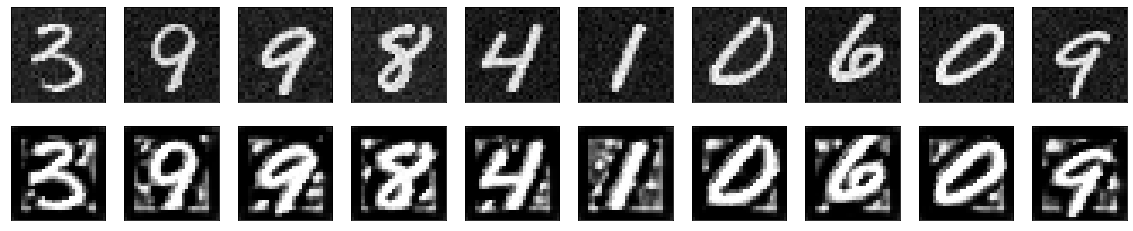

In [24]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(test_features[index].numpy().reshape(-1, 28, 28, 1)).numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Reload the test features, and increase the standard deviation of the Normal distribution from which we shall get the noise from for perturbing the test data.

In [25]:
_, (test_features, _) = mnist.load_data()

test_features = test_features.astype('float32') / 255.
test_features = test_features.reshape(-1, 28, 28, 1)
test_features += tf.random.normal(stddev=5e-1, shape=test_features.shape)

Get the last 5000 test features.

In [26]:
test_features = test_features[5000:]

Visualize the test features and the reconstructions.

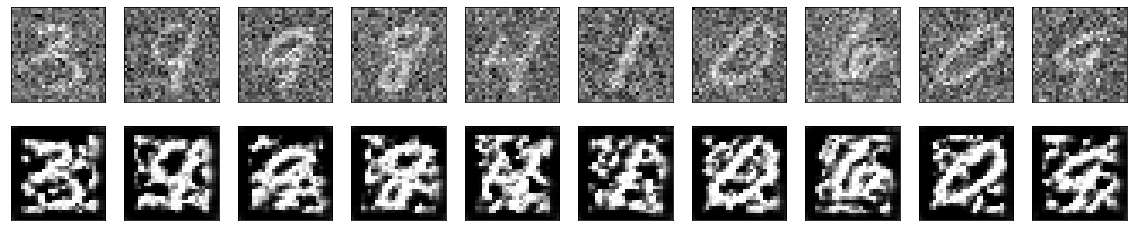

In [27]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(test_features[index].numpy().reshape(-1, 28, 28, 1)).numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Evaluate on the new perturbed test data.

In [28]:
clf.evaluate(test_features, test_labels, batch_size=batch_size, verbose=2)

5000/1 - 1s - loss: 1.8649 - accuracy: 0.7382


[1.4086255172729492, 0.7382]

In [29]:
model.save_weights('../assets/export/classifier/finetuning/mnist/100_epochs', save_format='tf')

Save the training history.

In [30]:
with open("../assets/export/classifier/finetuning/mnist/history.txt", "w") as file:
    file.write(repr(history.history))

We can load the history later.

In [ ]:
with open("../assets/export/classifier/finetuning/mnist/history.txt", "r") as file:
    data = file.read()
history = eval(data)